In [13]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import skimage as ski
import sklearn as skl
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from original_helpers import *
from new_helpers import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


In [2]:
# GLOBAL VARIABLES

TOTAL_IMAGES = 100 # Number of images to load
TRAIN_FRACTION = 0.9 # Percentage of images used for training
ANGLE_STEP = 36 # Gotta be 360/ANGLE_STEP needs to be an integer
FLIP = True # Flag to signal if flipped  versions of rotated images should also be created|

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(TOTAL_IMAGES, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [img_float_to_uint8(load_image(image_dir + files[i])) for i in range(n)]

train_size = int(TOTAL_IMAGES*TRAIN_FRACTION)
train_imgs = imgs[0:train_size]
test_imgs = imgs[train_size:]
imgs_rotated_flipped = rotate_imgs(train_imgs, ANGLE_STEP, FLIP)
train_imgs += imgs_rotated_flipped
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [img_float_to_uint8(load_image(gt_dir + files[i])) for i in range(n)]
train_gt_imgs = gt_imgs[0:train_size]
test_gt_imgs = gt_imgs[train_size:]
gt_imgs_rotated_flipped = rotate_imgs(train_gt_imgs, ANGLE_STEP, FLIP)
train_gt_imgs += gt_imgs_rotated_flipped
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


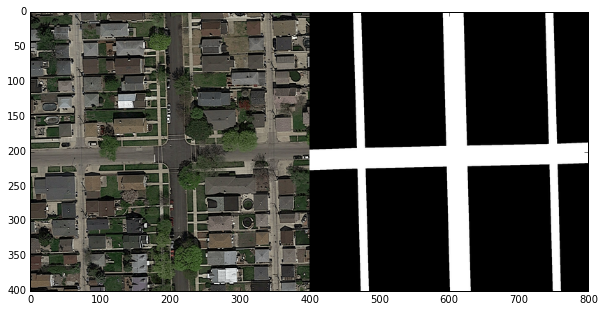

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

train_img_patches = extract_patches(train_imgs, patch_size)
train_gt_patches = extract_patches(train_gt_imgs, patch_size)
test_img_patches = extract_patches(test_imgs, patch_size)
test_gt_patches = extract_patches(test_gt_imgs, patch_size)

In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])
Xi = np.asarray([ extract_features(test_img_patches[i]) for i in range(len(test_img_patches))])
Yi = np.asarray([value_to_class(np.mean(test_gt_patches[i]), foreground_threshold) for i in range(len(test_gt_patches))])

In [7]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 1068750 features
Feature dimension = 6
Number of classes = 1
Class 0: 733044 samples
Class 1: 335706 samples


In [ ]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

In [ ]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)
logreg.score(X, Y)

In [ ]:
# Predict on the training set
Z = logreg.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y,Z)

In [ ]:
from sklearn.metrics import f1_score

f1_score(Y, Z, average='binary')

In [ ]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
display_prediction(imgs[img_idx], patch_size, Zi)

Let's follow scikit-learn algorithm cheat-sheet:

![ML-cheatsheet](http://scikit-learn.org/stable/_static/ml_map.png)

START -> >50 samples (YES) -> predicting a category (YES) -> labled data (YES) -> <100k samples (YES) -> 
### Linear SVC

In [ ]:
# train a logistic regression classifier

from sklearn import svm

# we create an instance of the classifier and fit the data
linearSVC = svm.LinearSVC(C=6.0, class_weight={1: 3})# class_weight="balanced"), class_weight="balanced")
linearSVC.fit(X, Y)
linearSVC.score(X, Y)

In [ ]:
# Predict on the training set
Z = linearSVC.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

In [ ]:
confusion_matrix(Y, Z)

In [ ]:
f1_score(Y, Z, average='binary')

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = linearSVC.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

START -> >50 samples (YES) -> predicting a category (YES) -> labled data (YES) -> <100k samples (YES) -> Linear SVC (Not Working) -> Text data (NO) -> 
### KNeighbors Classifier 

In [8]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X, Y) 
neigh.score(X ,Y)

0.89069660818713448

In [9]:
# Predict on the training set
Z = neigh.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

True positive rate = 0.20480748538011695


In [11]:
confusion_matrix(Y, Z)

array([[733044,      0],
       [116818, 218888]])

In [14]:
f1_score(Y, Z, average='binary')

0.78936302953151316

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

ERROR! Session/line number was not unique in database. History logging moved to new session 543


0.45041440411546158

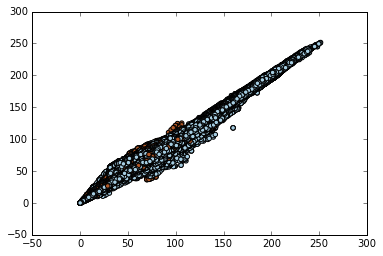

In [15]:
# Run prediction on the img_idx-th image
Zi = neigh.predict(Xi)
f1_score(Yi, Zi, average='binary')

### SVC

In [ ]:
from sklearn.svm import SVC
svc = SVC(C=1e6, class_weight={1: 4})
svc.fit(X, Y)
svc.score(X, Y)

In [ ]:
# Predict on the training set
Z = svc.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

In [ ]:
confusion_matrix(Y, Z)

In [ ]:
f1_score(Y, Z, average='binary')

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = svc.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

### Ensamble methods

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5)
forest.fit(X, Y)
forest.score(X, Y)

In [ ]:
# Predict on the training set
Z = forest.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

In [ ]:
confusion_matrix(Y, Z)

In [ ]:
f1_score(Y, Z, average='binary') #Yeah forest overfitts easily

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 92

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = forest.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

# MLPClassifier

 - Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization.
 
- from sklearn.preprocessing import StandardScaler  
    scaler = StandardScaler()  
    #Don't cheat - fit only on training data
    
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    apply same transformation to test data
    X_test = scaler.transform(X_test)  
    
- Finding a reasonable regularization parameter \alpha is best done using GridSearchCV, usually in the range '''10.0 \*\* -np.arange(1, 7)'''
- Empirically, we observed that L-BFGS converges faster and with better solutions on small datasets. For relatively large datasets, however, Adam is very robust. It usually converges quickly and gives pretty good performance. SGD with momentum or nesterov’s momentum, on the other hand, can perform better than those two algorithms if learning rate is correctly tuned.

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)  
X_train = scaler.transform(X)

In [17]:
clf = MLPClassifier()# default options
clf.fit(X_train, Y)
clf.score(X_train,Y)

0.77754105263157891

In [18]:
Xi = scaler.transform(Xi)  
Zi = clf.predict(Xi)

In [19]:
print('F1-score:', f1_score(Yi,Zi))

F1-score: 0.675446848542


In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000, solver='lbfgs', activation='logistic')
clf.fit(X_train, Y)
clf.score(X_train,Y)

In [ ]:
# Run prediction on the img_idx-th image
img_idx = 92

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Xi = scaler.transform(Xi)  
Zi = clf.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

In [ ]:
alpha = 10.0 ** -np.arange(1, 7)
alpha

In [ ]:
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()
scaler.fit(X)  
X_train = scaler.transform(X)

parameters = {'alpha': alpha}
clf = MLPClassifier()
gridCV = GridSearchCV(clf, parameters)
gridCV.fit(X_train, Y)

In [ ]:
sorted(gridCV.cv_results_.keys())

In [ ]:
print(gridCV.cv_results_['mean_train_score'])
print(gridCV.best_params_)